
# Q learning (Q-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    #     print('state, action, reward, done, info')
    #     print(state, action, reward, done, info)
    if done:
    #         print('state, action, reward, done, info')
    #         print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder/Classifier
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('qfunction', reuse=reuse):        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states,  actions, targetQs, # model input data 
               action_size, hidden_size): # model init
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_mask = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs_masked = tf.multiply(actions_logits, actions_mask)
    Qs = tf.reduce_max(Qs_masked, axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    return actions_logits, q_loss

In [10]:
def model_opt(q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)

    return q_opt

In [11]:
class QGAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input data

        # Update the model: backward pass and backprop
        self.q_opt = model_opt(q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [14]:
train_episodes = 500           # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 200               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()

model = QGAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
q_loss_list = [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    #     # Restore/load the trained model 
    #     #saver.restore(sess, 'checkpoints/model.ckpt')    
    #     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        q_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1) # boolean

            # Calculating targetQs = Rs + (gamma * nextQs)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)            
            next_actions_mask = (1 - episode_ends.astype(next_actions_logits.dtype)).reshape(-1, 1) 
            #nextQs = next_actions_logits * next_actions_mask
            nextQs_masked = np.multiply(next_actions_logits, next_actions_mask)
            nextQs = np.max(nextQs_masked, axis=1)

            # Bellman equation: Qs = Rs + (gamma * nextQs)
            targetQs = rewards + (gamma * nextQs)

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 54.0 Training q_loss: 4.4598 Explore P: 0.9947
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 15.0 Training q_loss: 8.5101 Explore P: 0.9932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 26.0 Training q_loss: 33.5627 Explore P: 0.9906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 8.0 Training q_loss: 66.2553 Explore P: 0.9899
-------------------------------------------------------------------------------
-----------------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 36 Total reward: 33.0 Training q_loss: 3830.7856 Explore P: 0.9254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 37 Total reward: 22.0 Training q_loss: 3986.1719 Explore P: 0.9234
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 38 Total reward: 41.0 Training q_loss: 3465.8213 Explore P: 0.9197
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 39 Total reward: 23.0 Training q_loss: 2133.5293 Explore P: 0.9176
-------------------------------------------------------------------------------
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 71 Total reward: 44.0 Training q_loss: 3256.7410 Explore P: 0.8545
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 8.0 Training q_loss: 4816.8442 Explore P: 0.8538
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 73 Total reward: 15.0 Training q_loss: 2706.3884 Explore P: 0.8525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 74 Total reward: 42.0 Training q_loss: 2977.7576 Explore P: 0.8490
-------------------------------------------------------------------------------
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 106 Total reward: 36.0 Training q_loss: 4546.3784 Explore P: 0.7482
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 107 Total reward: 27.0 Training q_loss: 10351.9990 Explore P: 0.7462
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 108 Total reward: 61.0 Training q_loss: 6892.4258 Explore P: 0.7417
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 109 Total reward: 22.0 Training q_loss: 8113.8945 Explore P: 0.7401
-------------------------------------------------------------------------------
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 142 Total reward: 11.0 Training q_loss: 3138472.2500 Explore P: 0.6152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 143 Total reward: 44.0 Training q_loss: 4147511.2500 Explore P: 0.6126
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 144 Total reward: 57.0 Training q_loss: 9199869.0000 Explore P: 0.6091
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 145 Total reward: 112.0 Training q_loss: 6859470.0000 Explore P: 0.6025
-------------------------------------------------------------------------------
---------------------------------------

-------------------------------------------------------------------------------
Episode: 176 Total reward: 170.0 Training q_loss: 361973120.0000 Explore P: 0.4490
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 177 Total reward: 199.0 Training q_loss: 423546304.0000 Explore P: 0.4404
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 178 Total reward: 143.0 Training q_loss: 938768448.0000 Explore P: 0.4343
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 179 Total reward: 199.0 Training q_loss: 989475136.0000 Explore P: 0.4259
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 210 Total reward: 199.0 Training q_loss: 7935956992.0000 Explore P: 0.2492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 211 Total reward: 199.0 Training q_loss: 11960877056.0000 Explore P: 0.2445
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 212 Total reward: 199.0 Training q_loss: 13796699136.0000 Explore P: 0.2399
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 213 Total reward: 199.0 Training q_loss: 3505457664.0000 Explore P: 0.2354
-------------------------------------------------------------------------------
----------------------

-------------------------------------------------------------------------------
Episode: 244 Total reward: 199.0 Training q_loss: 4360537088.0000 Explore P: 0.1328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 245 Total reward: 182.0 Training q_loss: 13778354176.0000 Explore P: 0.1306
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 246 Total reward: 166.0 Training q_loss: 14590402560.0000 Explore P: 0.1286
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 247 Total reward: 199.0 Training q_loss: 17565007872.0000 Explore P: 0.1263
-------------------------------------------------------------------------------
---------------------

-------------------------------------------------------------------------------
Episode: 278 Total reward: 106.0 Training q_loss: 129771651072.0000 Explore P: 0.0745
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Training q_loss: 176418406400.0000 Explore P: 0.0733
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 195.0 Training q_loss: 147061915648.0000 Explore P: 0.0720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 197.0 Training q_loss: 130046017536.0000 Explore P: 0.0708
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 312 Total reward: 199.0 Training q_loss: 178493784064.0000 Explore P: 0.0428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 313 Total reward: 199.0 Training q_loss: 134611615744.0000 Explore P: 0.0422
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 314 Total reward: 199.0 Training q_loss: 195724443648.0000 Explore P: 0.0415
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 315 Total reward: 199.0 Training q_loss: 147907723264.0000 Explore P: 0.0409
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Training q_loss: 4483049984.0000 Explore P: 0.0267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Training q_loss: 2883414016.0000 Explore P: 0.0264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 199.0 Training q_loss: 423332608.0000 Explore P: 0.0260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 199.0 Training q_loss: 1872456064.0000 Explore P: 0.0257
-------------------------------------------------------------------------------
-------------------------

-------------------------------------------------------------------------------
Episode: 380 Total reward: 111.0 Training q_loss: 41595564032.0000 Explore P: 0.0186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 381 Total reward: 199.0 Training q_loss: 51907710976.0000 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 382 Total reward: 196.0 Training q_loss: 87647518720.0000 Explore P: 0.0182
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 383 Total reward: 199.0 Training q_loss: 58338410496.0000 Explore P: 0.0181
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 414 Total reward: 199.0 Training q_loss: 81655234560.0000 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 415 Total reward: 199.0 Training q_loss: 48695607296.0000 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 199.0 Training q_loss: 79985106944.0000 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 199.0 Training q_loss: 73307078656.0000 Explore P: 0.0141
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 448 Total reward: 199.0 Training q_loss: 57381244928.0000 Explore P: 0.0123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 449 Total reward: 199.0 Training q_loss: 57688350720.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 450 Total reward: 199.0 Training q_loss: 95784075264.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 451 Total reward: 199.0 Training q_loss: 65022427136.0000 Explore P: 0.0122
-------------------------------------------------------------------------------
--------------------

-------------------------------------------------------------------------------
Episode: 482 Total reward: 161.0 Training q_loss: 78573215744.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 483 Total reward: 199.0 Training q_loss: 53670391808.0000 Explore P: 0.0112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 484 Total reward: 199.0 Training q_loss: 73477423104.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 199.0 Training q_loss: 93159202816.0000 Explore P: 0.0111
-------------------------------------------------------------------------------
--------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

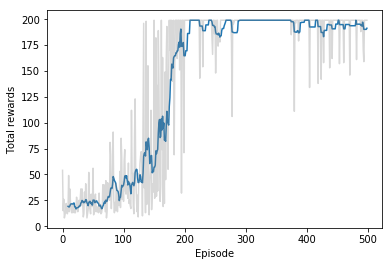

In [19]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Q losses')

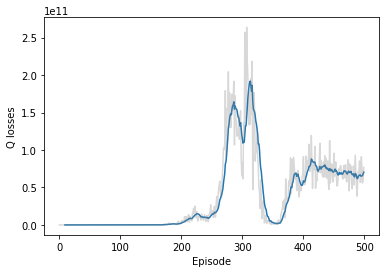

In [20]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [55]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/QGAN-cartpole.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [56]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.